# MHA per Head Probe Accuracies Heatmap

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os # For path manipulation, if needed
import matplotlib.colors as mcolors # Moved import to the top

def plot_mha_heatmap(accuracies, model_id, num_layers, num_heads,
                     sort_layer_accuracies=None, font_sizes=None,
                     output_pdf_path=None, color_scheme='importance'):
    """
    Plots a heatmap for MHA accuracies and shows it.
    Optionally saves the plot to a PDF file if `output_pdf_path` is provided.

    Accuracies can be sorted within each layer if `sort_layer_accuracies`
    is set to 'ascending' or 'descending'. Otherwise, original head order is used.
    Font sizes and styles for various plot elements can be configured via the `font_sizes` dict.
    Color schemes can be chosen to better represent the concept of importance.

    Args:
        accuracies (dict): Dictionary with keys like 'layer_head' (e.g., '0_1')
                           and values as accuracy percentages.
        model_id (str): Identifier for the model, used in the plot title.
        num_layers (int): Total number of layers in the model.
        num_heads (int): Total number of attention heads per layer.
        sort_layer_accuracies (str, optional): If 'ascending' or 'descending',
                                               sorts accuracies within each layer.
                                               Defaults to None (original head order).
        font_sizes (dict, optional): Dictionary to override default font sizes and styles for
                                     'title', 'xlabel', 'ylabel', 'xticks', 'yticks',
                                     'colorbar_label', 'colorbar_ticks',
                                     'xtick_rotation', 'xtick_interval'.
                                     Defaults to None (uses default_font_config).
        output_pdf_path (str, optional): If provided, the path (including filename)
                                         where the plot will be saved as a PDF.
                                         Example: 'my_plot.pdf'. Defaults to None.
        color_scheme (str, optional): Color scheme to use. Options include:
                                     'importance' (default): gray to red
                                     'warm': gray to orange/red
                                     'cool': gray to blue
                                     'diverging': blue through gray to red
                                     'plasma': gray to plasma colors
                                     'inferno': gray to inferno colors
                                     'clusters'/'importance_clusters': 3-level importance
                                     'discrete_clusters': 3-level importance (sharp boundaries)
    """
    print("Generating MHA heatmap...")

    # --- Font size and style configuration ---
    default_font_config = {
        'title': 18,
        'xlabel': 16,
        'ylabel': 16,
        'xticks': 14,         # Font size for x-tick labels
        'yticks': 14,         # Font size for y-tick labels
        'colorbar_label': 16,
        'colorbar_ticks': 14,
        'xtick_rotation': 45, # Default rotation for x-tick labels
        'xtick_interval': None # Default interval for x-ticks (None means adaptive)
    }
    if font_sizes is None:
        current_font_sizes = default_font_config
    else:
        current_font_sizes = default_font_config.copy()
        current_font_sizes.update(font_sizes)

    # --- Data processing ---
    rows = []
    for key, value in accuracies.items():
        try:
            layer, head = map(int, key.split('_'))
            rows.append({'layer': layer, 'head': head, 'accuracy': value})
        except ValueError:
            print(f"Warning: Could not parse key '{key}' as layer_head. Skipping.")
            continue

    if not rows:
        print("No valid data to plot for MHA heatmap (parsed data is empty).")
        # Consider creating an empty plot or returning if truly no data
        # For now, it will proceed and likely show an empty plot with labels.

    df = pd.DataFrame(rows)
    accuracy_matrix_original_order = np.full((num_layers, num_heads), np.nan)

    if not df.empty:
        for index, row in df.iterrows():
            if 0 <= row['layer'] < num_layers and 0 <= row['head'] < num_heads:
                accuracy_matrix_original_order[int(row['layer']), int(row['head'])] = row['accuracy']
            else:
                print(f"Warning: Data point layer {row['layer']}, head {row['head']} out of bounds. Skipping.")

    display_matrix = np.copy(accuracy_matrix_original_order)
    xlabel_text = 'Head Index'

    if sort_layer_accuracies in ['ascending', 'descending']:
        print(f"Sorting accuracies within each layer ({sort_layer_accuracies})...")
        temp_sorted_matrix = np.full((num_layers, num_heads), np.nan)
        for i in range(num_layers):
            layer_row = accuracy_matrix_original_order[i, :]
            nan_mask = np.isnan(layer_row)
            valid_values = layer_row[~nan_mask]
            if valid_values.size > 0:
                if sort_layer_accuracies == 'ascending':
                    sorted_valid_values = np.sort(valid_values)
                else: # descending
                    sorted_valid_values = np.sort(valid_values)[::-1]
                temp_sorted_matrix[i, :len(sorted_valid_values)] = sorted_valid_values
        display_matrix = temp_sorted_matrix
        if sort_layer_accuracies == 'ascending':
            xlabel_text = 'Head Rank (sorted ascending by accuracy within layer)'
        elif sort_layer_accuracies == 'descending':
            xlabel_text = 'Head Rank (sorted descending by accuracy within layer)'
    elif sort_layer_accuracies is not None:
        print(f"Warning: Invalid value '{sort_layer_accuracies}' for sort_layer_accuracies. No sorting.")

    # --- Color scheme selection ---
    norm = None # Initialize norm for discrete_clusters
    n_bins_cmap = 256 # Default number of bins for continuous colormaps

    if color_scheme == 'clusters' or color_scheme == 'importance_clusters':
        # Designed for data values expected roughly in 40-100 range
        # Nodes are normalized, so imshow's vmin/vmax will map to these.
        nodes = [0.0, 0.75, 0.8, 1.0] # Relative positions for 40, 60, 85, 100
        cluster_map_colors = ['#f0f0f0', '#b0b0b0', '#FF9500', '#ff0000']
        # Ensure nodes are monotonically increasing and within [0,1]
        valid_nodes = []
        valid_colors = []
        last_node = -1.0
        for node, color in zip(nodes, cluster_map_colors):
            if 0.0 <= node <= 1.0 and node > last_node:
                valid_nodes.append(node)
                valid_colors.append(color)
                last_node = node
            else:
                print(f"Warning: Invalid node {node} for 'clusters' colormap. Skipping.")
        if not valid_nodes or valid_nodes[0] != 0.0: # Ensure first node is 0
            valid_nodes.insert(0, 0.0)
            valid_colors.insert(0, cluster_map_colors[0]) # Use first color
        if valid_nodes[-1] != 1.0: # Ensure last node is 1
             valid_nodes.append(1.0)
             valid_colors.append(cluster_map_colors[-1]) # Use last color

        cmap = mcolors.LinearSegmentedColormap.from_list(
            'importance_clusters', list(zip(valid_nodes, valid_colors)), N=n_bins_cmap
        )
    elif color_scheme == 'importance' or color_scheme == 'warm':
        colors = ['lightgray', 'gray', '#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']
        cmap = mcolors.LinearSegmentedColormap.from_list('gray_red', colors, N=n_bins_cmap)
    elif color_scheme == 'cool':
        colors = ['lightgray', 'gray', '#9999ff', '#6666ff', '#3333ff', '#0000ff', '#0000cc']
        cmap = mcolors.LinearSegmentedColormap.from_list('gray_blue', colors, N=n_bins_cmap)
    elif color_scheme == 'diverging':
        colors = ['#0000cc', '#6666ff', 'lightgray', '#ff6666', '#cc0000'] # Simplified
        cmap = mcolors.LinearSegmentedColormap.from_list('blue_gray_red', colors, N=n_bins_cmap)
    elif color_scheme == 'plasma':
        cmap_base = plt.cm.get_cmap('plasma').copy()
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom_plasma", ['lightgray'] + [cmap_base(i) for i in np.linspace(0.1, 1, n_bins_cmap-1)], N=n_bins_cmap
        ) # Prepend lightgray for values near/below vmin
    elif color_scheme == 'inferno':
        cmap_base = plt.cm.get_cmap('inferno').copy()
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom_inferno", ['lightgray'] + [cmap_base(i) for i in np.linspace(0.1, 1, n_bins_cmap-1)], N=n_bins_cmap
        )
    elif color_scheme == 'discrete_clusters':
        from matplotlib.colors import ListedColormap, BoundaryNorm
        cluster_colors = ['#f0f0f0', '#b0c4de', '#ff4500'] # Irrelevant, Neutral, Important
        bounds = [40, 60, 85, 100] # Data values defining boundaries
        cmap = ListedColormap(cluster_colors)
        norm = BoundaryNorm(bounds, cmap.N) # norm maps data values to colormap indices
    else:
        colors = ['lightgray', 'gray', '#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']
        cmap = mcolors.LinearSegmentedColormap.from_list('default_gray_red', colors, N=n_bins_cmap)
        print(f"Warning: Unrecognized color scheme '{color_scheme}'. Using default 'importance' scheme.")

    cmap.set_bad('white')  # Missing values (NaNs) shown in white

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(7, 7)) # User's preferred figsize

    max_acc_from_df = df['accuracy'].max() if not df.empty and 'accuracy' in df.columns and df['accuracy'].notna().any() else np.nan
    vmin_val = 40
    # Ensure vmax_val is sensible
    vmax_val = max(vmin_val + 1, 90, max_acc_from_df if pd.notna(max_acc_from_df) else vmin_val + 10)


    if display_matrix.shape[0] == 0 or display_matrix.shape[1] == 0 or np.all(np.isnan(display_matrix)):
        print("Warning: Display matrix is empty or all NaNs. Cannot create heatmap image.")
        ax.text(0.5, 0.5, "No data to display", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        # Set labels and title even for an empty plot for consistency
    else:
        if color_scheme == 'discrete_clusters' and norm:
            heatmap = ax.imshow(display_matrix, cmap=cmap, aspect='auto', norm=norm) # norm handles vmin/vmax implicitly
            # For discrete, colorbar ticks should correspond to the segments
            cbar_ticks = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
            cbar = plt.colorbar(heatmap, ax=ax, boundaries=bounds, ticks=cbar_ticks)
            # Optionally, set custom tick labels for discrete clusters:
            # cbar.ax.set_yticklabels([f'{bounds[i]}-{bounds[i+1]}%' for i in range(len(bounds)-1)])
        else: # For continuous colormaps
            heatmap = ax.imshow(display_matrix, cmap=cmap, aspect='auto', vmin=vmin_val, vmax=vmax_val)
            cbar = plt.colorbar(heatmap, ax=ax)

        cbar.set_label('Accuracy (%)', fontsize=current_font_sizes['colorbar_label'])
        cbar.ax.tick_params(labelsize=current_font_sizes['colorbar_ticks'])

    ax.set_xlabel(xlabel_text, fontsize=current_font_sizes['xlabel'])
    ax.set_ylabel('Layer Index', fontsize=current_font_sizes['ylabel'])
    ax.set_title(f'Probe Accuracy Heatmap by Layer and Head (MHA)\n{model_id}', fontsize=current_font_sizes['title'])

    # --- X-axis ticks ---
    if num_heads > 0:
        user_xtick_interval = current_font_sizes.get('xtick_interval')
        step = 1 # Default step

        if user_xtick_interval and isinstance(user_xtick_interval, int) and user_xtick_interval > 0:
            step = user_xtick_interval
        else: # Default adaptive step calculation
            if num_heads <= 16: # If 16 or fewer heads, show every head
                step = 1
            else: # More than 16 heads, calculate step to show around 16 ticks
                target_display_ticks = 16.0
                step = max(1, int(round(num_heads / target_display_ticks)))
        
        ticks_to_show = np.arange(0, num_heads, step)
        if len(ticks_to_show) == 0 : # Ensure at least one tick if num_heads > 0
             ticks_to_show = np.array([0]) if num_heads == 1 else np.array([])


        ax.set_xticks(ticks_to_show)
        ax.tick_params(axis='x', labelsize=current_font_sizes['xticks'], rotation=current_font_sizes['xtick_rotation'])
    else:
        ax.set_xticks([])

    # --- Y-axis ticks ---
    if num_layers > 0:
        # Adaptive y-ticks, similar to default x-tick logic but for layers
        if num_layers <= 12:
            y_step = 1
        elif num_layers <= 24:
            y_step = 2
        else:
            y_step = max(1, num_layers // 12) # Aim for ~12 y-ticks
        ax.set_yticks(np.arange(0, num_layers, y_step))
        ax.tick_params(axis='y', labelsize=current_font_sizes['yticks'])
    else:
        ax.set_yticks([])

    plt.tight_layout()

    if output_pdf_path:
        try:
            output_dir = os.path.dirname(output_pdf_path)
            if output_dir and not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created directory: {output_dir}")
            plt.savefig(output_pdf_path, format='pdf', bbox_inches='tight', dpi=300)
            print(f"Plot saved to {output_pdf_path}")
        except Exception as e:
            print(f"Error saving plot to {output_pdf_path}: {e}")

    plt.show()
    plt.close(fig)
    print("MHA heatmap generation complete.")


# # Example usage:
# if __name__ == "__main__":
#     sample_accuracies_large = {}
#     np.random.seed(42)
#     num_l_large = 24
#     num_h_large = 64 # Many heads to test tick skipping
#     for layer in range(num_l_large):
#         for head in range(num_h_large):
#             accuracy = 40 + np.random.beta(2 + layer/4, 5 - layer/10) * 55
#             sample_accuracies_large[f"{layer}_{head}"] = accuracy

#     print("\n--- Example with many heads (default tick interval) ---")
    # plot_mha_heatmap(
    #     accuracies=sample_accuracies_large,
    #     model_id="Large Model (Default X-Ticks)",
    #     num_layers=num_l_large,
    #     num_heads=num_h_large,
    #     color_scheme='inferno',
    #     font_sizes={'xtick_rotation': 60, 'xticks': 8} # Smaller font for many rotated ticks
    # 

Generating MHA heatmap...
Plot saved to gemma-3_mha_heatmap.pdf


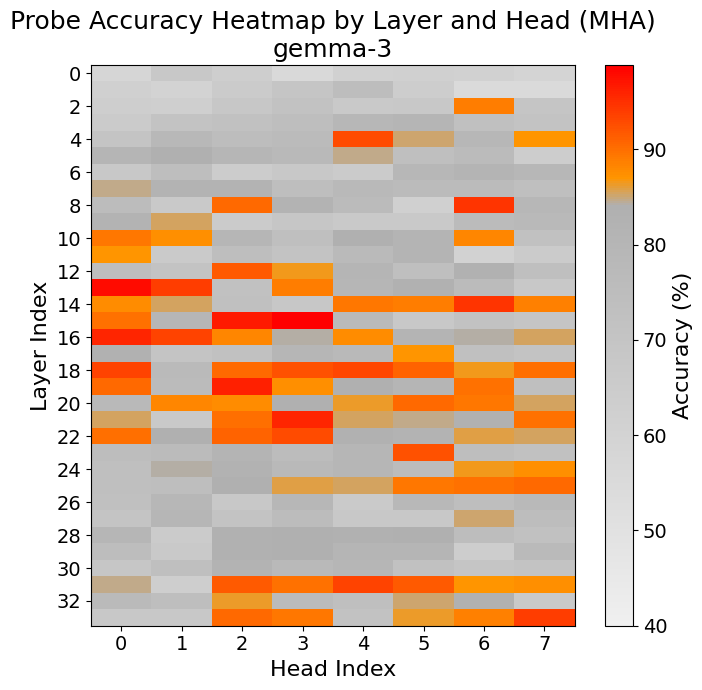

MHA heatmap generation complete.


In [3]:
import pickle as pkl

model_id = 'gemma-3'
accuracies = pkl.load(open(f'linear_probe/trained_probe/gemma-3-4b-it/accuracies_dict_mha.pkl', 'rb'))
# accuracies = pkl.load(open(f'linear_probe/trained_probe/Qwen3-4B-Instruct-2507/accuracies_dict_mha.pkl', 'rb'))
# accuracies = pkl.load(open(f'linear_probe/trained_probe/Llama-3.2-3B-Instruct/accuracies_dict_mha.pkl', 'rb'))
if 'gemma' in model_id:
    NUM_HEADS = 8
    NUM_LAYERS = 34
elif 'qwen-3' in model_id:
    NUM_HEADS = 36
    NUM_LAYERS = 32
else: # Assuming Llama-like structure otherwise
    NUM_LAYERS = 28
    NUM_HEADS = 24

# plot_mha_heatmap(accuracies, model_id, NUM_LAYERS, NUM_HEADS, sort_layer_accuracies=None, output_pdf_path=f'{model_id}_mha_heatmap.pdf', color_scheme="clusters")

plot_mha_heatmap(
    accuracies=accuracies,
    model_id=model_id,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    color_scheme='clusters',
    font_sizes={'xtick_rotation': 0}, # Smaller font for many rotated ticks,
    output_pdf_path=f'{model_id}_mha_heatmap.pdf'
)

In [10]:
len([acc for acc in accuracies.values() if int(acc) >= 85])/len(accuracies)*100

71

# MLP or Residual per Layer Probe Accuracies Line Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any, Optional, List
import os # Import os for directory operations

def plot_layer_line(
    accuracies: Dict[Any, float],
    model_id: str,
    num_layers: int, # Total number of layers in the model, used for xtick generation fallback
    output_dir: Optional[str] = None, # Original parameter, noted as no longer used
    activation_type: str = "Activation",
    font_options: Optional[Dict[str, int]] = None,
    pdf_output_path: Optional[str] = None # New parameter to specify PDF output path
):
    """
    Plots a line graph for layer-wise accuracies and shows it.
    Optionally saves the plot as a PDF if pdf_output_path is provided.
    The order of points in the line plot will depend on the iteration order
    of the input 'accuracies' dictionary. This function does NOT sort the
    accuracies data before plotting the line. Font sizes for plot elements
    can be customized via the 'font_options' dictionary.

    Args:
        accuracies (Dict[Any, float]): Dictionary of layer accuracies.
            Keys are layer identifiers, values are accuracies.
            The plot will connect points in the dictionary's iteration order.
        model_id (str): Identifier for the model, used in the plot title.
        num_layers (int): Total number of actual layers in the model. This might be used
                          as a fallback for determining x-axis tick marks if layer
                          identifiers are numeric but sparse or not fully provided from `accuracies.keys()`.
        output_dir (Optional[str]): No longer used. Kept for signature compatibility.
        activation_type (str): Type of activation, used in the plot title.
        font_options (Optional[Dict[str, int]]): Dictionary to customize font sizes.
            Expected keys: 'title', 'axis_label', 'tick_label', 'legend_text'.
            Example: {'title': 16, 'axis_label': 14, 'tick_label': 12, 'legend_text': 12}
        pdf_output_path (Optional[str]): If provided, the path (including filename.pdf)
            where the plot will be saved as a PDF. Example: "plots/my_model_plot.pdf".
    """
    # (output_dir is no longer used, as per original comment)

    # Define default font sizes
    default_fonts = {
        'title': 24,
        'axis_label': 20,
        'tick_label': 16,
        'legend_text': 16,
    }
    # Update defaults with any user-provided font sizes
    current_fonts = default_fonts.copy()
    if font_options:
        current_fonts.update(font_options)

    print(f"Generating Layer-wise line plot for {activation_type}...")
    if not accuracies:
        print(f"No data provided for {activation_type} layer-wise line plot.")
        return

    # Prepare data for plotting.
    # 'processed_layers' will store x-axis values (layer identifiers).
    # 'accuracies_list' will store y-axis values (accuracies).
    # Their order is determined by the 'accuracies' dictionary's iteration order.
    keys_from_dict = list(accuracies.keys())
    accuracies_list = list(accuracies.values())
    
    processed_layers: List[Any]
    x_axis_is_numeric: bool

    try:
        processed_layers = [int(k) for k in keys_from_dict]
        x_axis_is_numeric = True
    except (ValueError, TypeError):
        if all(isinstance(k, (int, float)) for k in keys_from_dict):
            processed_layers = keys_from_dict
            x_axis_is_numeric = True
        else:
            print(f"Warning: Layer keys for {activation_type} plot are not uniformly integers or simple numeric types. Treating all layer identifiers as strings for categorical plotting.")
            processed_layers = [str(k) for k in keys_from_dict]
            x_axis_is_numeric = False

    plt.figure(figsize=(12, 6))
    plt.plot(processed_layers, accuracies_list, marker='o', linestyle='-', linewidth=2, markersize=8, color='#3366cc')
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Chance level (50%)')

    if accuracies_list:
        best_layer_idx = np.argmax(accuracies_list)
        best_layer_val = processed_layers[best_layer_idx]
        best_accuracy_val = accuracies_list[best_layer_idx]
        
        plt.scatter(best_layer_val, best_accuracy_val, color='red', s=150, zorder=5,
                    label=f'Best: Layer {best_layer_val} ({best_accuracy_val:.2f}%)')

        min_val_for_ylim = min(accuracies_list)
        max_val_for_ylim = max(accuracies_list)
        plt.ylim(min(40, min_val_for_ylim - 5), max(90, max_val_for_ylim + 5))
    else:
        plt.ylim(35, 95)

    plt.xlabel('Layer Number' if x_axis_is_numeric else 'Layer Identifier', fontsize=current_fonts['axis_label'])
    plt.ylabel('Validation Accuracy (%)', fontsize=current_fonts['axis_label'])
    plt.title(f'Probe Accuracy by Layer ({activation_type} output) - {model_id}', fontsize=current_fonts['title'])
    plt.grid(True, alpha=0.3)

    if x_axis_is_numeric:
        unique_numeric_layers = sorted(list(set(l for l in processed_layers if isinstance(l, (int, float)))))
        if unique_numeric_layers:
            tick_step = max(1, len(unique_numeric_layers) // 14 if len(unique_numeric_layers) > 14 else 1)
            plt.xticks(ticks=unique_numeric_layers[::tick_step])
        elif num_layers > 0:
            step = max(1, num_layers // 14 if num_layers > 0 else 1)
            plt.xticks(ticks=np.arange(0, num_layers, step))
    else:
        if len(processed_layers) > 10:
             plt.xticks(rotation=45, ha="right")

    plt.tick_params(axis='both', which='major', labelsize=current_fonts['tick_label'])
    plt.legend(loc='best', fontsize=current_fonts['legend_text'])
    plt.tight_layout()

    # --- SAVE PLOT AS PDF ---
    if pdf_output_path:
        try:
            # Ensure the directory exists if pdf_output_path includes a directory
            output_directory = os.path.dirname(pdf_output_path)
            if output_directory and not os.path.exists(output_directory): # Check if output_directory is not empty
                os.makedirs(output_directory)
                print(f"Created directory: {output_directory}")
            
            plt.savefig(pdf_output_path, format='pdf', bbox_inches='tight')
            print(f"Plot saved as PDF to: {pdf_output_path}")
        except Exception as e:
            print(f"Error saving plot to PDF at {pdf_output_path}: {e}")
    # --- END SAVE PLOT ---

    plt.show()
    plt.close() # Close figure



In [ ]:
import pickle as pkl

model_id = 'llama'
activation_type = 'residual'
accuracies = pkl.load(open(f'linear_probe/trained_probe/{model_id}/accuracies_dict_{activation_type}.pkl', 'rb'))
if 'gemma' in model_id:
    NUM_HEADS = 8
    NUM_LAYERS = 34
else: # Assuming Llama-like structure otherwise
    NUM_LAYERS = 28
    NUM_HEADS = 24

plot_layer_line(accuracies, model_id, NUM_LAYERS, NUM_HEADS, activation_type, pdf_output_path=f'{model_id}_{activation_type}_linechart.pdf')

# Hyperparameters Heatmap

In [89]:
from utils import compute_accuracy
import json
model='gemma-3'
TOP_K_HEADS=[16, 32, 48, 64]
SCALES=[-20, -10, 10, 20]

initial_accuracies = [] # list of list [[for strength in scales] for k in k_heads]
final_accuracies = []
shifts = []
kl_divergences = [[0.03, 0.01, 0.01, 0.03], [0.07, 0.02, 0.03, 0.12], [0.12, 0.03, 0.04, 0.18], [0.15, 0.04, 0.05, 0.21]] # Computed in another program
for k in TOP_K_HEADS:
    current_k_initial_accuracies = []
    current_k_final_accuracies = []
    current_k_shifts = []
    for strength in SCALES:
        initial_predictions = []
        with open(f'evaluation_jsonl/truthfulqa-{model}_initial_iti_{k}_{strength}.0.jsonl', 'r') as file:
        # with open(f'evaluation_jsonl/truthfulqa-{model}_initial_base.jsonl', 'r') as file:
            for line in file:
                json_object = json.loads(line.strip())
                initial_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

        final_predictions = []
        with open(f'evaluation_jsonl/truthfulqa-{model}_final_iti_{k}_{strength}.0.jsonl', 'r') as file:
        # with open(f'evaluation_jsonl/truthfulqa-{model}_final_base.jsonl', 'r') as file:
            for line in file:
                json_object = json.loads(line.strip())
                final_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

        initial_accuracy = compute_accuracy(initial_predictions)
        current_k_initial_accuracies.append(initial_accuracy)
        final_accuracy = compute_accuracy(final_predictions)
        current_k_final_accuracies.append(final_accuracy)
        
        correct_to_incorrect_count = 0
        initial_correct_count = 0
        for y1, y2 in zip(initial_predictions, final_predictions):
            if y1 == "CORRECT" and y2 == "INCORRECT":
                correct_to_incorrect_count+=1
            if y1 == "CORRECT":
                initial_correct_count+=1
        shift = correct_to_incorrect_count/initial_correct_count
        current_k_shifts.append(shift)
    initial_accuracies.append(current_k_initial_accuracies)
    final_accuracies.append(current_k_final_accuracies)
    shifts.append(current_k_shifts)

# initial_accuracies, final_accuracies, shifts

## Initial Accuracy

Plot saved to initial_accuracy_mha_hyperparam.pdf


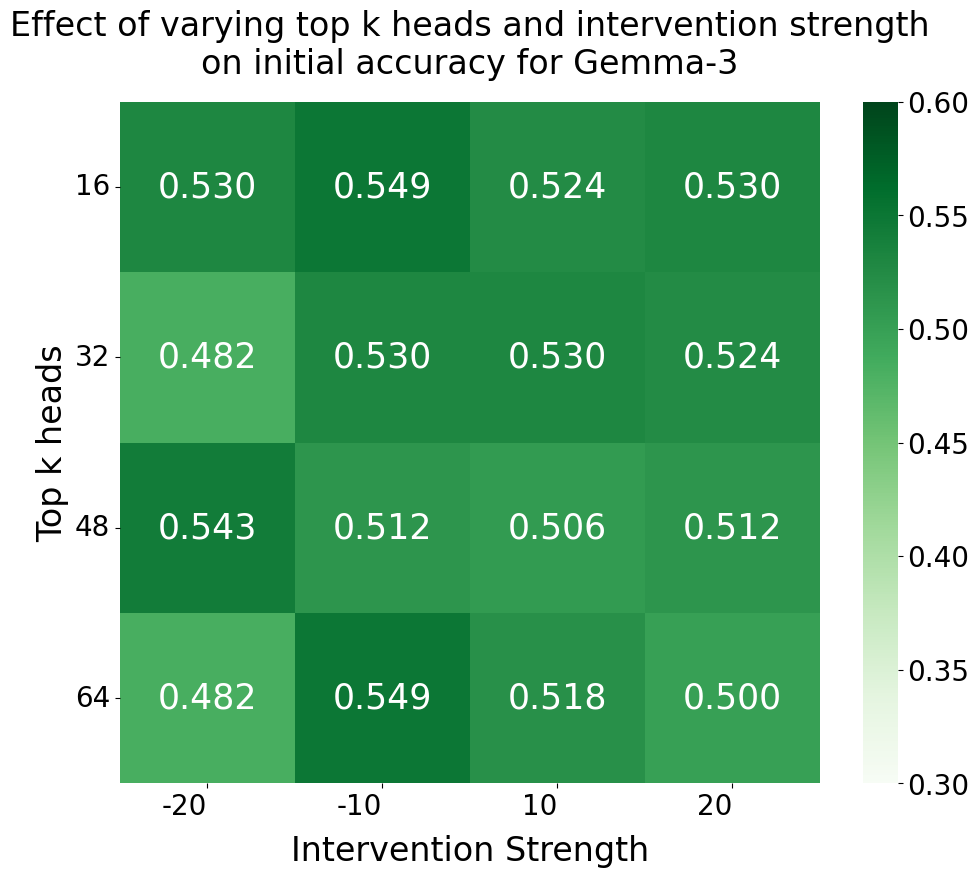

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Font sizes
title_fontsize = 24
axis_label_fontsize = 24
xtick_fontsize = 20  # Customizable X-tick font size
ytick_fontsize = 20  # Customizable Y-tick font size
annotation_fontsize = 25 # For heatmap cell annotations
colorbar_label_fontsize = 20 # For the colorbar label
colorbar_tick_fontsize = 20 # For the colorbar ticks

# Figure and Plot settings
figure_width = 10 # Adjusted slightly to accommodate colorbar better
figure_height = 9
heatmap_cmap = "Greens"
heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".3f"
colorbar_label_text = ""
tight_layout_pad = 1.5 # Padding for tight_layout

# Output file
output_filename = "initial_accuracy_mha_hyperparam.pdf"
# --- End Customizable Parameters ---


# Create a DataFrame
df = pd.DataFrame(initial_accuracies, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
plt.figure(figsize=(figure_width, figure_height))

# Create the heatmap
heatmap = sns.heatmap(df,
                      annot=True,
                      cmap=heatmap_cmap,
                      vmin=heatmap_vmin,
                      vmax=heatmap_vmax,
                      annot_kws={"size": annotation_fontsize, "weight": "normal"}, # Adjusted weight
                      fmt=heatmap_fmt,
                      cbar=True,  # Ensure colorbar is present
                      cbar_kws={'label': colorbar_label_text} # Add label to colorbar
                     )

# Customize colorbar label font size and tick font size
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)


# Add title and labels
plt.title("Effect of varying top k heads and intervention strength\non initial accuracy for Gemma-3",
          fontsize=title_fontsize, pad=20) # Added some padding to title
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10)
plt.ylabel("Top k heads", fontsize=axis_label_fontsize)

# Set tick label font size
plt.xticks(fontsize=xtick_fontsize, ha="right") # Added rotation for better readability if scales are long
plt.yticks(fontsize=ytick_fontsize, rotation=0)

# Adjust layout to make sure everything fits
plt.tight_layout(pad=tight_layout_pad)

# Save the plot to PDF
# It's often good to save before plt.show()
# bbox_inches='tight' ensures the saved figure includes all elements without extra whitespace
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

# Display the plot
plt.show()

## Final Accuracy

Plot saved to final_accuracy_mha_hyperparam.pdf


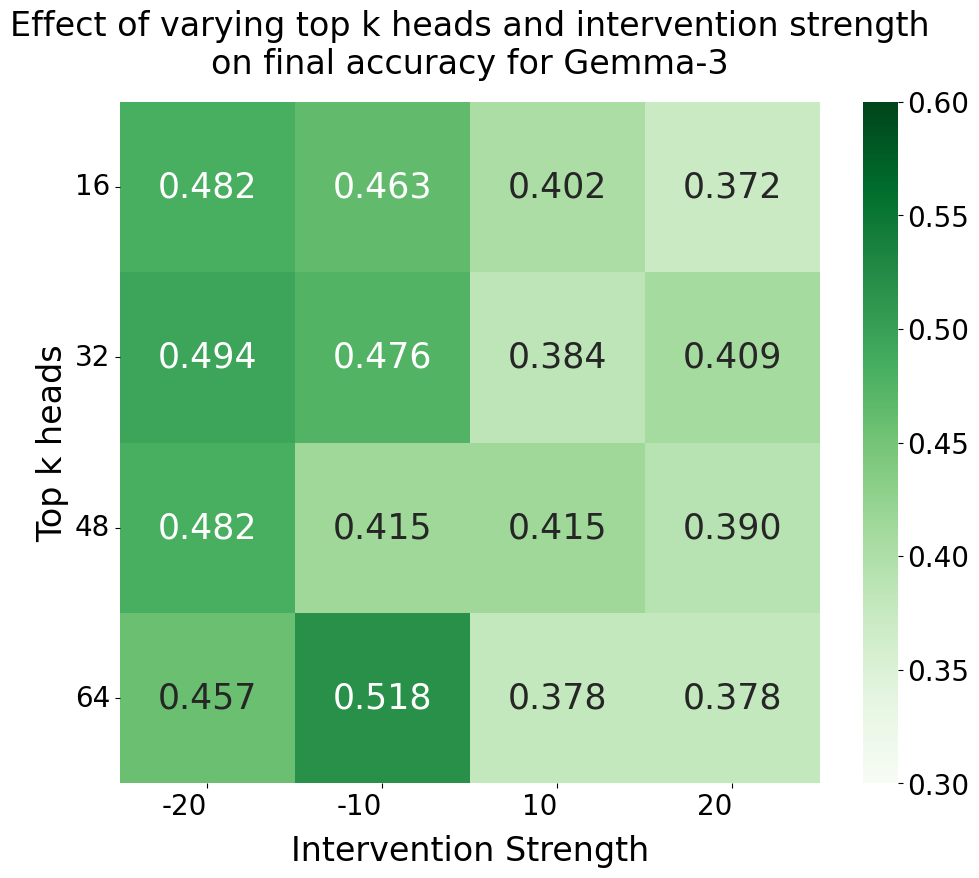

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Font sizes
title_fontsize = 24
axis_label_fontsize = 24
xtick_fontsize = 20  # Customizable X-tick font size
ytick_fontsize = 20  # Customizable Y-tick font size
annotation_fontsize = 25 # For heatmap cell annotations
colorbar_label_fontsize = 20 # For the colorbar label
colorbar_tick_fontsize = 20 # For the colorbar ticks

# Figure and Plot settings
figure_width = 10 # Adjusted slightly to accommodate colorbar better
figure_height = 9
heatmap_cmap = "Greens"
heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".3f"
colorbar_label_text = ""
tight_layout_pad = 1.5 # Padding for tight_layout

# Output file
output_filename = "final_accuracy_mha_hyperparam.pdf"
# --- End Customizable Parameters ---


# Create a DataFrame
df = pd.DataFrame(final_accuracies, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
plt.figure(figsize=(figure_width, figure_height))

# Create the heatmap
heatmap = sns.heatmap(df,
                      annot=True,
                      cmap=heatmap_cmap,
                      vmin=heatmap_vmin,
                      vmax=heatmap_vmax,
                      annot_kws={"size": annotation_fontsize, "weight": "normal"}, # Adjusted weight
                      fmt=heatmap_fmt,
                      cbar=True,  # Ensure colorbar is present
                      cbar_kws={'label': colorbar_label_text} # Add label to colorbar
                     )

# Customize colorbar label font size and tick font size
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)


# Add title and labels
plt.title("Effect of varying top k heads and intervention strength\non final accuracy for Gemma-3",
          fontsize=title_fontsize, pad=20) # Added some padding to title
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10)
plt.ylabel("Top k heads", fontsize=axis_label_fontsize)

# Set tick label font size
plt.xticks(fontsize=xtick_fontsize, ha="right") # Added rotation for better readability if scales are long
plt.yticks(fontsize=ytick_fontsize, rotation=0)

# Adjust layout to make sure everything fits
plt.tight_layout(pad=tight_layout_pad)

# Save the plot to PDF
# It's often good to save before plt.show()
# bbox_inches='tight' ensures the saved figure includes all elements without extra whitespace
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

# Display the plot
plt.show()

## Shift

Plot saved to shift_to_incorrect_mha_hyperparam.pdf


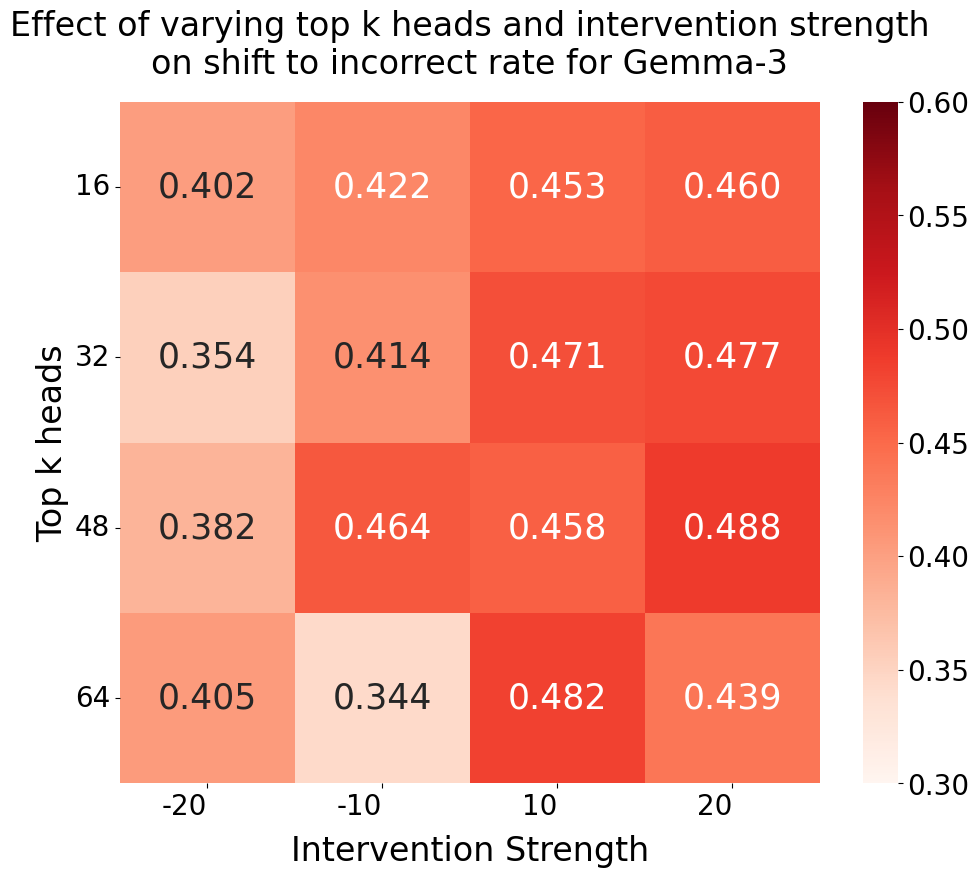

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Font sizes
title_fontsize = 24
axis_label_fontsize = 24
xtick_fontsize = 20  # Customizable X-tick font size
ytick_fontsize = 20  # Customizable Y-tick font size
annotation_fontsize = 25 # For heatmap cell annotations
colorbar_label_fontsize = 20 # For the colorbar label
colorbar_tick_fontsize = 20 # For the colorbar ticks

# Figure and Plot settings
figure_width = 10 # Adjusted slightly to accommodate colorbar better
figure_height = 9
heatmap_cmap = "Reds"
heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".3f"
colorbar_label_text = ""
tight_layout_pad = 1.5 # Padding for tight_layout

# Output file
output_filename = "shift_to_incorrect_mha_hyperparam.pdf"
# --- End Customizable Parameters ---


# Create a DataFrame
df = pd.DataFrame(shifts, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
plt.figure(figsize=(figure_width, figure_height))

# Create the heatmap
heatmap = sns.heatmap(df,
                      annot=True,
                      cmap=heatmap_cmap,
                      vmin=heatmap_vmin,
                      vmax=heatmap_vmax,
                      annot_kws={"size": annotation_fontsize, "weight": "normal"}, # Adjusted weight
                      fmt=heatmap_fmt,
                      cbar=True,  # Ensure colorbar is present
                      cbar_kws={'label': colorbar_label_text} # Add label to colorbar
                     )

# Customize colorbar label font size and tick font size
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)


# Add title and labels
plt.title("Effect of varying top k heads and intervention strength\non shift to incorrect rate for Gemma-3",
          fontsize=title_fontsize, pad=20) # Added some padding to title
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10)
plt.ylabel("Top k heads", fontsize=axis_label_fontsize)

# Set tick label font size
plt.xticks(fontsize=xtick_fontsize, ha="right") # Added rotation for better readability if scales are long
plt.yticks(fontsize=ytick_fontsize, rotation=0)

# Adjust layout to make sure everything fits
plt.tight_layout(pad=tight_layout_pad)

# Save the plot to PDF
# It's often good to save before plt.show()
# bbox_inches='tight' ensures the saved figure includes all elements without extra whitespace
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

# Display the plot
plt.show()

## KL Divergence

Plot saved to kl_divergences_mha_hyperparam.pdf


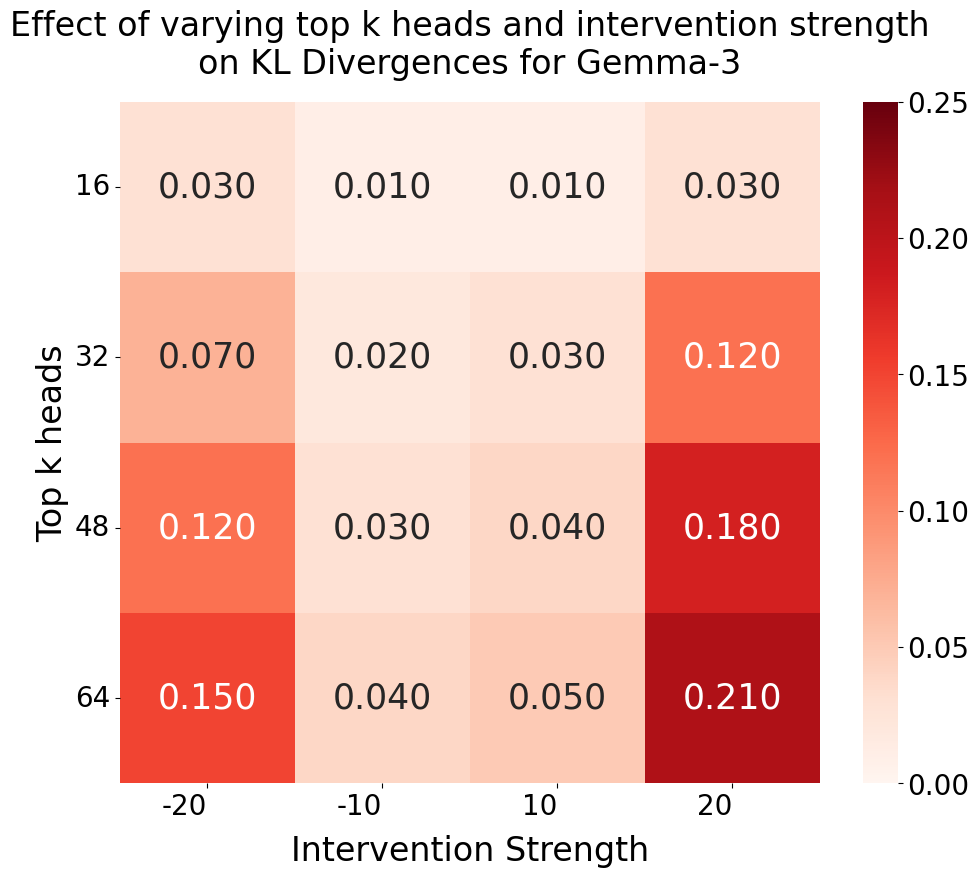

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Font sizes
title_fontsize = 24
axis_label_fontsize = 24
xtick_fontsize = 20  # Customizable X-tick font size
ytick_fontsize = 20  # Customizable Y-tick font size
annotation_fontsize = 25 # For heatmap cell annotations
colorbar_label_fontsize = 18 # For the colorbar label
colorbar_tick_fontsize = 20 # For the colorbar ticks

# Figure and Plot settings
figure_width = 10 # Adjusted slightly to accommodate colorbar better
figure_height = 9
heatmap_cmap = "Reds"
heatmap_vmin = 0
heatmap_vmax = 0.25
heatmap_fmt = ".3f"
colorbar_label_text = ""
tight_layout_pad = 1.5 # Padding for tight_layout

# Output file
output_filename = "kl_divergences_mha_hyperparam.pdf"
# --- End Customizable Parameters ---


# Create a DataFrame
df = pd.DataFrame(kl_divergences, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
plt.figure(figsize=(figure_width, figure_height))

# Create the heatmap
heatmap = sns.heatmap(df,
                      annot=True,
                      cmap=heatmap_cmap,
                      vmin=heatmap_vmin,
                      vmax=heatmap_vmax,
                      annot_kws={"size": annotation_fontsize, "weight": "normal"}, # Adjusted weight
                      fmt=heatmap_fmt,
                      cbar=True,  # Ensure colorbar is present
                      cbar_kws={'label': colorbar_label_text} # Add label to colorbar
                     )

# Customize colorbar label font size and tick font size
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)

# Add title and labels
plt.title("Effect of varying top k heads and intervention strength\non KL Divergences for Gemma-3",
          fontsize=title_fontsize, pad=20) # Added some padding to title
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10)
plt.ylabel("Top k heads", fontsize=axis_label_fontsize)

# Set tick label font size
plt.xticks(fontsize=xtick_fontsize, ha="right") # Added rotation for better readability if scales are long
plt.yticks(fontsize=ytick_fontsize, rotation=0)

# Adjust layout to make sure everything fits
plt.tight_layout(pad=tight_layout_pad)

# Save the plot to PDF
# It's often good to save before plt.show()
# bbox_inches='tight' ensures the saved figure includes all elements without extra whitespace
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

# Display the plot
plt.show()

# Residual or MLP Intervention Strength

## Figure 4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Seaborn works well with pandas for grouped bar charts

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 18
LABEL_FONT_SIZE = 16
TICK_FONT_SIZE = 14
LEGEND_FONT_SIZE = 12

# --- Simulate Data ---
# Let's assume these are for an "Residual Intervention" scenario
intervention_strengths = np.array([-20, -10, 0, 10, 20]) # 0 is no intervention
n_strengths = len(intervention_strengths)

initial_accuracy_residual = np.array([0.46341463414634143,
   0.5304878048780488,
   0.52,
   0.5304878048780488,
   0.47560975609756095])

# Final Accuracy: Drops or stays same/worse than no-intervention (strength 0)
final_accuracy_residual = np.array([0.36585365853658536, 0.38414634146341464,0.372, 0.3414634146341463, 0.33536585365853655])

# Shift to Incorrect: No clear beneficial linear trend, might even worsen
shift_to_incorrect_residual = np.array([0.4342105263157895,
   0.4605263157894737,
   0.517, # This is the baseline_shift_residual
   0.4942528735632184,
   0.47435897435897434])

# --- Find No Intervention (Baseline) Data ---
baseline_idx = np.where(intervention_strengths == 0)[0][0]
baseline_initial_acc_residual = initial_accuracy_residual[baseline_idx]
baseline_final_acc_residual = final_accuracy_residual[baseline_idx]
baseline_shift_residual = shift_to_incorrect_residual[baseline_idx]

# --- Plot Option 2: "Delta from Baseline" Line Plot ---
delta_initial_accuracy_residual = initial_accuracy_residual - baseline_initial_acc_residual
delta_final_accuracy_residual = final_accuracy_residual - baseline_final_acc_residual
delta_shift_to_incorrect_residual = shift_to_incorrect_residual - baseline_shift_residual

# --- Y-axis limit control ---
# Determine min and max y values from the delta data
all_delta_values = np.concatenate((delta_initial_accuracy_residual, delta_final_accuracy_residual, delta_shift_to_incorrect_residual))
# Using hardcoded values as per your previous script for data_min_y and data_max_y
# If you want to dynamically calculate them from all_delta_values:
data_min_y = np.min(all_delta_values)
data_max_y = np.max(all_delta_values)

# --- ADJUSTABLE Y-LIMITS ---
# Set to True to use manual y_min and y_max, False for automatic padding
USE_MANUAL_YLIMITS = False # <--- CHANGE THIS TO True TO USE MANUAL VALUES
MANUAL_Y_MIN = -0.10   # <--- SET YOUR DESIRED MIN Y VALUE HERE
MANUAL_Y_MAX = 0.10    # <--- SET YOUR DESIRED MAX Y VALUE HERE
PADDING_FACTOR = 0.1 # 10% padding if not using manual limits

if USE_MANUAL_YLIMITS:
    plot_y_min = MANUAL_Y_MIN
    plot_y_max = MANUAL_Y_MAX
else:
    y_range = data_max_y - data_min_y
    if y_range == 0: # Handle case where all delta values are the same (e.g., all zero)
        padding = 0.1 # Default padding if range is zero
    else:
        padding = y_range * PADDING_FACTOR

    plot_y_min = data_min_y - padding
    plot_y_max = data_max_y + padding
    # Ensure 0 is nicely visible if it's within the padded range or close
    if plot_y_min < 0 < plot_y_max:
        abs_max_delta = max(abs(plot_y_min), abs(plot_y_max))
        plot_y_min = -abs_max_delta
        plot_y_max = abs_max_delta
    elif plot_y_min > -padding/2:
        plot_y_min = min(plot_y_min, -padding/2)
    elif plot_y_max < padding/2:
        plot_y_max = max(plot_y_max, padding/2)


fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(intervention_strengths, delta_initial_accuracy_residual, marker='o', linestyle='-', label='Δ Initial Accuracy from Baseline', color='cornflowerblue', linewidth=2)
ax2.plot(intervention_strengths, delta_final_accuracy_residual, marker='o', linestyle='-', label='Δ Final Accuracy from Baseline', color='forestgreen', linewidth=2)
ax2.plot(intervention_strengths, delta_shift_to_incorrect_residual, marker='o', linestyle='-', label='Δ Shift to Incorrect from Baseline', color='crimson', linewidth=2)

ax2.axhline(0, color='darkgrey', linewidth=1.0, linestyle='--', label='Baseline (No Change)')

# --- Apply Font Sizes ---
ax2.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('Change from Baseline Value', fontsize=LABEL_FONT_SIZE)
ax2.set_title('Delta from Baseline for Residual Stream Intervention', fontsize=TITLE_FONT_SIZE)

# Apply font size to tick labels
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)

# Apply the determined y-limits
ax2.set_ylim(plot_y_min, plot_y_max)

ax2.legend(fontsize=LEGEND_FONT_SIZE)
# ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle=':', alpha=0.6, color='lightgray')
fig2.tight_layout() # Adjust layout to prevent overlapping labels

# Save the figure before showing it
plt.savefig('residual_intervention_strength.pdf', bbox_inches='tight') # Added bbox_inches='tight'
plt.show()

## Figure 5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Seaborn works well with pandas for grouped bar charts

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 18
LABEL_FONT_SIZE = 16
TICK_FONT_SIZE = 14
LEGEND_FONT_SIZE = 12


# --- Simulate Data ---
# Let's assume these are for an "MLP Intervention" scenario
intervention_strengths = np.array([-20, -10, 0, 10, 20]) # 0 is no intervention
n_strengths = len(intervention_strengths)

initial_accuracy_mlp = np.array([0.4512195121951219,
   0.47560975609756095,
   0.52,
   0.47560975609756095,
   0.4024390243902439])
final_accuracy_mlp = np.array([0.300, 0.370, 0.370, 0.430, 0.320])
shift_to_incorrect_mlp = np.array([0.550, 0.480, 0.510, 0.350, 0.490])

baseline_idx = np.where(intervention_strengths == 0)[0][0]
baseline_init_acc_mlp = initial_accuracy_mlp[baseline_idx]
baseline_final_acc_mlp = final_accuracy_mlp[baseline_idx]
baseline_shift_mlp = shift_to_incorrect_mlp[baseline_idx]

# --- Plot Option 2: "Delta from Baseline" Line Plot ---
delta_initial_accuracy_mlp = initial_accuracy_mlp - baseline_init_acc_mlp
delta_final_accuracy_mlp = final_accuracy_mlp - baseline_final_acc_mlp
delta_shift_to_incorrect_mlp = shift_to_incorrect_mlp - baseline_shift_mlp

# --- Y-axis limit control ---
# Option 1: Automatic padding (calculates min/max from data and adds some space)
# Option 2: Manual override (set specific values)

# Determine min and max y values from the delta data
all_delta_values = np.concatenate((delta_initial_accuracy_mlp, delta_final_accuracy_mlp, delta_shift_to_incorrect_mlp))
data_min_y = np.min(all_delta_values)
data_max_y = np.max(all_delta_values)

# --- ADJUSTABLE Y-LIMITS ---
# Set to True to use manual y_min and y_max, False for automatic padding
USE_MANUAL_YLIMITS = False # <--- CHANGE THIS TO True TO USE MANUAL VALUES
MANUAL_Y_MIN = -0.10   # <--- SET YOUR DESIRED MIN Y VALUE HERE
MANUAL_Y_MAX = 0.10    # <--- SET YOUR DESIRED MAX Y VALUE HERE
PADDING_FACTOR = 0.1 # 10% padding if not using manual limits

if USE_MANUAL_YLIMITS:
    plot_y_min = MANUAL_Y_MIN
    plot_y_max = MANUAL_Y_MAX
else:
    y_range = data_max_y - data_min_y
    if y_range == 0: # Handle case where all delta values are the same (e.g., all zero)
        padding = 0.1 # Default padding if range is zero
    else:
        padding = y_range * PADDING_FACTOR

    plot_y_min = data_min_y - padding
    plot_y_max = data_max_y + padding
    # Ensure 0 is nicely visible if it's within the padded range or close
    if plot_y_min < 0 < plot_y_max:
        # If 0 is within the range, try to make the plot symmetrical if sensible
        # or at least ensure 0 isn't too close to an edge.
        # This is a simple heuristic, can be refined.
        abs_max_delta = max(abs(plot_y_min), abs(plot_y_max))
        plot_y_min = -abs_max_delta
        plot_y_max = abs_max_delta
    elif plot_y_min > -padding/2: # if min is very close to 0 from below
        plot_y_min = min(plot_y_min, -padding/2) # push it a bit further from 0
    elif plot_y_max < padding/2: # if max is very close to 0 from above
        plot_y_max = max(plot_y_max, padding/2) # push it a bit further from 0


fig2, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(intervention_strengths, delta_initial_accuracy_mlp, marker='o', linestyle='-', label='Δ Initial Accuracy from Baseline', color='cornflowerblue', linewidth=2)
ax2.plot(intervention_strengths, delta_final_accuracy_mlp, marker='o', linestyle='-', label='Δ Final Accuracy from Baseline', color='forestgreen', linewidth=2)
ax2.plot(intervention_strengths, delta_shift_to_incorrect_mlp, marker='o', linestyle='-', label='Δ Shift to Incorrect from Baseline', color='crimson', linewidth=2)

ax2.axhline(0, color='darkgrey', linewidth=1.0, linestyle='--', label='Baseline (No Change)') # Made baseline more prominent
# --- Apply Font Sizes ---
ax2.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('Change from Baseline Value', fontsize=LABEL_FONT_SIZE)
ax2.set_title('Delta from Baseline for MLP Intervention', fontsize=TITLE_FONT_SIZE)

# Apply font size to tick labels
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)

# Apply the determined y-limits
ax2.set_ylim(plot_y_min, plot_y_max)

ax2.legend(fontsize=LEGEND_FONT_SIZE)
# ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle=':', alpha=0.6, color='lightgray')
fig2.tight_layout() # Adjust layout to prevent overlapping labels
plt.savefig('mlp_intervention_strength.pdf')
plt.show()

# Other plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 16
SUBPLOT_TITLE_FONT_SIZE = 14
LABEL_FONT_SIZE = 12
TICK_FONT_SIZE = 10
LEGEND_FONT_SIZE = 10

# --- COLORS (Inspired by common academic plots and paper's use of distinct colors) ---
COLOR_MLP = '#1f77b4'  # Blue
COLOR_RESIDUAL = '#2ca02c' # Green
COLOR_MHA = '#d62728' # Red (often used for emphasis or a key comparison)
COLOR_BASELINE_HLINE = 'darkgrey' # For the y=0 horizontal line

# --- LINE WIDTHS ---
LINEWIDTH_STD = 1.8
LINEWIDTH_EMPHASIS = 2.5 # For MHA if it's the focus
LINEWIDTH_BASELINE_HLINE = 1.0

# --- Intervention Strengths (Assuming same for all for comparison) ---
intervention_strengths = np.array([-20, -15, -10, -5, 0, 5, 10, 15, 20]) # Extended for smoother plot

# --- Simulated/Placeholder Data (Extended to match new intervention_strengths) ---
original_strengths = np.array([-20, -10, 0, 10, 20])

# MLP Data
original_initial_accuracy_mlp = np.array([0.4512195121951219, 0.47560975609756095, 0.52, 0.47560975609756095, 0.4024390243902439])
original_shift_to_incorrect_mlp = np.array([0.550, 0.480, 0.510, 0.350, 0.490])

# Residual Stream Data
original_initial_accuracy_residual = np.array([0.46341463414634143, 0.5304878048780488, 0.52, 0.5304878048780488, 0.47560975609756095])
original_shift_to_incorrect_residual = np.array([0.4342105263157895, 0.4605263157894737, 0.517, 0.4942528735632184, 0.47435897435897434])

# MHA Data
original_initial_accuracy_mha = np.array([0.55, 0.55, 0.523, 0.522, 0.50])
original_shift_to_incorrect_mha = np.array([0.34, 0.34, 0.41, 0.48, 0.44])

# Interpolate data for smoother plot
initial_accuracy_mlp = np.interp(intervention_strengths, original_strengths, original_initial_accuracy_mlp)
shift_to_incorrect_mlp = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_mlp)

initial_accuracy_residual = np.interp(intervention_strengths, original_strengths, original_initial_accuracy_residual)
shift_to_incorrect_residual = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_residual)

initial_accuracy_mha = np.interp(intervention_strengths, original_strengths, original_initial_accuracy_mha)
shift_to_incorrect_mha = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_mha)


# --- Calculate Baselines (Value at Intervention Strength 0) ---
baseline_idx = np.where(intervention_strengths == 0)[0][0]

baseline_initial_acc_mlp = initial_accuracy_mlp[baseline_idx]
baseline_shift_mlp = shift_to_incorrect_mlp[baseline_idx]

baseline_initial_acc_residual = initial_accuracy_residual[baseline_idx]
baseline_shift_residual = shift_to_incorrect_residual[baseline_idx]

baseline_initial_acc_mha = initial_accuracy_mha[baseline_idx]
baseline_shift_mha = shift_to_incorrect_mha[baseline_idx]

# --- Calculate Deltas from Baseline ---
# Shift to Incorrect (signed)
delta_shift_mlp = shift_to_incorrect_mlp - baseline_shift_mlp
delta_shift_residual = shift_to_incorrect_residual - baseline_shift_residual
delta_shift_mha = shift_to_incorrect_mha - baseline_shift_mha

# Initial Accuracy (absolute delta)
abs_delta_initial_acc_mlp = np.abs(initial_accuracy_mlp - baseline_initial_acc_mlp)
abs_delta_initial_acc_residual = np.abs(initial_accuracy_residual - baseline_initial_acc_residual)
abs_delta_initial_acc_mha = np.abs(initial_accuracy_mha - baseline_initial_acc_mha)


# --- Create the 2x1 Subplot Figure ---
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True) # Adjusted figsize for better aspect ratio

# --- Plot 1: Delta Shift to Incorrect ---
ax1 = axs[0]
ax1.plot(intervention_strengths, delta_shift_mlp, label='MLP', color=COLOR_MLP, linewidth=LINEWIDTH_STD, marker='o', markersize=4, alpha=0.8)
ax1.plot(intervention_strengths, delta_shift_residual, label='Residual', color=COLOR_RESIDUAL, linewidth=LINEWIDTH_STD, marker='s', markersize=4, alpha=0.8)
ax1.plot(intervention_strengths, delta_shift_mha, label='MHA', color=COLOR_MHA, linewidth=LINEWIDTH_EMPHASIS, marker='^', markersize=5, alpha=0.8)

ax1.axhline(0, color=COLOR_BASELINE_HLINE, linewidth=LINEWIDTH_BASELINE_HLINE, linestyle='--', label='Baseline (No Change)')
ax1.set_ylabel('Δ Shift to Incorrect\n(Lower is Better)', fontsize=LABEL_FONT_SIZE)
ax1.set_title('Impact on Sycophancy (Shift to Incorrect)', fontsize=SUBPLOT_TITLE_FONT_SIZE)
ax1.legend(fontsize=LEGEND_FONT_SIZE, loc='best', frameon=False) # Changed loc for potentially better placement
ax1.grid(True, linestyle=':', alpha=0.6, color='lightgray')
ax1.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

# --- Plot 2: Absolute Delta Initial Accuracy ---
ax2 = axs[1]
ax2.plot(intervention_strengths, abs_delta_initial_acc_mlp, label='MLP', color=COLOR_MLP, linewidth=LINEWIDTH_STD, marker='o', markersize=4, alpha=0.8)
ax2.plot(intervention_strengths, abs_delta_initial_acc_residual, label='Residual', color=COLOR_RESIDUAL, linewidth=LINEWIDTH_STD, marker='s', markersize=4, alpha=0.8)
ax2.plot(intervention_strengths, abs_delta_initial_acc_mha, label='MHA', color=COLOR_MHA, linewidth=LINEWIDTH_EMPHASIS, marker='^', markersize=5, alpha=0.8)

# ax2.axhline(0, color=COLOR_BASELINE_HLINE, linewidth=LINEWIDTH_BASELINE_HLINE, linestyle='--', label='No Change from Baseline') # Baseline is now the x-axis
ax2.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('|Δ Initial Accuracy|\n(Lower is Better)', fontsize=LABEL_FONT_SIZE)
ax2.set_title('Magnitude of Impact on Initial Accuracy', fontsize=SUBPLOT_TITLE_FONT_SIZE)
# ax2.legend(fontsize=LEGEND_FONT_SIZE, loc='best', frameon=False) # Legend can be omitted if clear from above
ax2.grid(True, linestyle=':', alpha=0.6, color='lightgray')
ax2.tick_params(axis='both', labelsize=TICK_FONT_SIZE)


# --- Overall Figure Title and Layout ---
fig.suptitle('Comparative Effect of Intervention Strategies vs. Strength', fontsize=TITLE_FONT_SIZE, y=0.98)
fig.tight_layout(rect=[0, 0.02, 1, 0.95]) # rect adjusts for suptitle and bottom x-label

# --- Y-axis limit control ---
def get_padded_limits_signed(data_values, padding_factor=0.15, symmetrize_around_zero=True):
    # Add 0 to data_values to ensure baseline is considered for range calculation
    data_values_with_zero = np.append(data_values, 0)
    min_val_eff = np.min(data_values_with_zero)
    max_val_eff = np.max(data_values_with_zero)

    data_range = max_val_eff - min_val_eff
    if data_range == 0: data_range = abs(min_val_eff) * 0.2 if abs(min_val_eff) > 0 else 0.2
    
    padding = data_range * padding_factor
    plot_min = min_val_eff - padding
    plot_max = max_val_eff + padding
    
    if symmetrize_around_zero and plot_min < 0 < plot_max:
        abs_extreme = max(abs(plot_min), abs(plot_max))
        return -abs_extreme, abs_extreme
    elif symmetrize_around_zero and plot_min >= 0 and plot_max >=0: # all positive
        return max(plot_min - padding, -0.01), plot_max # Ensure 0 is slightly visible if min is near 0
    elif symmetrize_around_zero and plot_min <= 0 and plot_max <=0: # all negative
        return plot_min, min(plot_max + padding, 0.01)
        
    return plot_min, plot_max

def get_padded_limits_abs(data_values, padding_factor=0.1):
    # For absolute values, the minimum is 0 (or very close to it)
    min_val_eff = 0 # Or np.min(data_values) if you don't want to force 0
    max_val_eff = np.max(data_values)
    
    data_range = max_val_eff - min_val_eff # min_val_eff is 0
    if data_range == 0: data_range = max_val_eff * 0.2 if max_val_eff > 0 else 0.1 # handle if all values are 0

    padding = data_range * padding_factor
    plot_min = -padding * 0.1 # Start slightly below 0 for visual spacing
    plot_max = max_val_eff + padding
    return plot_min, plot_max


all_delta_shift_values = np.concatenate((delta_shift_mlp, delta_shift_residual, delta_shift_mha))
all_abs_delta_acc_values = np.concatenate((abs_delta_initial_acc_mlp, abs_delta_initial_acc_residual, abs_delta_initial_acc_mha))

y_lim_shift = get_padded_limits_signed(all_delta_shift_values, symmetrize_around_zero=True)
y_lim_abs_acc = get_padded_limits_abs(all_abs_delta_acc_values)


ax1.set_ylim(y_lim_shift)
ax2.set_ylim(y_lim_abs_acc)


# --- Save and Show ---
plt.savefig('intervention_comparison_trends.pdf', bbox_inches='tight')
# plt.savefig('intervention_comparison_trends_abs_acc.png', bbox_inches='tight', dpi=300)
plt.show()

# Sankey

In [ ]:
import json
model = 'gemma-3'
k = 64
strength = -20
initial_state = []
# with open(f'evaluation_jsonl/truthfulqa-{model}_initial_iti_{k}_{strength}.0.jsonl', 'r') as file:
with open(f'evaluation_jsonl/truthfulqa-{model}_initial_base.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        initial_state.append(json_object['response']['body']['choices'][0]['message']['content'])

final_state = []
# with open(f'evaluation_jsonl/truthfulqa-{model}_final_iti_{k}_{strength}.0.jsonl', 'r') as file:
with open(f'evaluation_jsonl/truthfulqa-{model}_final_base.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        final_state.append(json_object['response']['body']['choices'][0]['message']['content'])

stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect = 0, 0, 0, 0
correct_to_incorrect_ids = []
incorrect_to_correct_ids = []
for i, (initial, final) in enumerate(zip(initial_state, final_state)):
    if initial == 'CORRECT' and final == 'CORRECT':
        stay_correct += 1
    elif initial == 'CORRECT' and final == 'INCORRECT':
        correct_to_incorrect += 1
        correct_to_incorrect_ids.append(i)
    elif initial == 'INCORRECT' and final == 'CORRECT':
        incorrect_to_correct += 1
        incorrect_to_correct_ids.append(i)
    elif initial == 'INCORRECT' and final == 'INCORRECT':
        stay_incorrect += 1

print(stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect)

import plotly.graph_objects as go
import plotly.io as pio

# Configure Kaleido to not load MathJax
pio.kaleido.scope.mathjax = None

# Define nodes
nodes = ["Correct (Initial)", "Incorrect (Initial)", "Correct (Final)", "Incorrect (Final)"]

# Define links (source, target, value)
links = {
    "source": [0, 0, 1, 1],
    "target": [2, 3, 2, 3],
    "value": [stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect],
}
 
correct_color = "rgba(162, 210, 162, 0.45)" # Soft emerald green
incorrect_color = "rgba(255, 160, 122, 0.45)" # Light salmon
correct_to_incorrect = "rgba(255, 160, 122, 0.8)" # Light sky-blue
incorrect_to_correct = "rgba(173, 216, 230, 0.45)" # Soft emerald green

node_colors = [
    correct_color,  # Correct Initial  
    incorrect_color,  # Incorrect Initial  
    correct_color,  # Correct Final  
    incorrect_color,  # Incorrect Final  
]

link_colors = [
    correct_color,  # Correct Always  
    correct_to_incorrect,  # Correct Always
    incorrect_to_correct,  # Incorrect Always
    incorrect_color,  # Incorrect Always
]


fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20,
        color=node_colors,
        line=dict(color="rgba(50, 50, 50, 0.2)", width=0.5)
    ),
    link=dict(
        source=links["source"],
        target=links["target"],
        value=links["value"],
        color=link_colors
    )
)])

fig.update_layout(
    font=dict(family="Inter, -apple-system, Arial, sans-serif",
              size=10),  # Increased font size from 12 to 16, removed global color
    width=360,  # Slightly increased width to accommodate larger text
    height=200,  # Slightly increased height
    margin=dict(l=25, r=25, t=30, b=25),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Make node labels more visible with bold font, appropriate colors, and text outline
# Using CSS text-shadow to create an outline effect around the text
node_text_colors = ["darkgrey", "darkgrey", "darkgrey", "darkgrey"]  # Color for each node's text
outline_colors = ["darkgrey", "darkgrey", "darkgrey", "darkgrey"]  # Outline color for each node's text


# Font Style 1 
# fig.update_traces(
#     node=dict(
#         label=[f'<b><span style="color: {text_color}; text-shadow: -1px -1px 0 {outline}, 1px -1px 0 {outline}, -1px 1px 0 {outline}, 1px 1px 0 {outline}, 0px 1px 0 {outline}, 0px -1px 0 {outline}, 1px 0px 0 {outline}, -1px 0px 0 {outline};">{label}</span></b>' 
#                for label, text_color, outline in zip(nodes, node_text_colors, outline_colors)],
#     )
# )

# Font Style 2
# fig.update_traces(
#     node=dict(
#         label=[f'<span style="font-family: Inter, -apple-system, Arial, sans-serif; font-weight: 600; color: {text_color}; text-shadow: 0px 0px 2px {outline};">{label}</span>' 
#                for label, text_color, outline in zip(nodes, node_text_colors, outline_colors)],
#     )
# )

# Saving the figure
output_pdf_file = "sankey_diagram.pdf"
try:
    fig.write_image(output_pdf_file)
    print(f"Figure saved as {output_pdf_file}")
except Exception as e:
    print(f"Error saving figure: {e}")
    print("Make sure you have kaleido installed: pip install -U kaleido")

# Display the figure
fig.show()

# Attention Head Pattern

In [ ]:
import pickle

accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe/gemma-3-4b-it/accuracies_dict_mha.pkl', 'rb'))
sorted_items = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

from datasets import load_dataset

ds = load_dataset("truthfulqa/truthful_qa", "generation")
ds_train = ds['validation'][:int(0.8*len(ds['validation']))]
questions = ds_train['question']
correct_answers = ds_train['correct_answers']
incorrect_answers = ds_train['incorrect_answers']

from linear_probe.linear_probe_data_utils import construct_data
chats, labels = con struct_data(ds_train, model='gemma')

from bertviz import model_view, head_view
from transformers import Gemma3ForConditionalGeneration, AutoProcessor
import torch

# Load model and processor
model = Gemma3ForConditionalGeneration.from_pretrained("google/gemma-3-4b-it", device_map="auto", output_attentions=True)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

# [('15_2', 83.96946564885496),
#  ('13_0', 83.58778625954199),
#  ('12_2', 83.20610687022901),
#  ('20_4', 83.20610687022901),
#  ('16_0', 82.82442748091603),
#  ('15_3', 82.44274809160305),
#  ('16_1', 82.44274809160305),
#  ('31_5', 82.44274809160305),
#  ('18_4', 82.06106870229007),
#  ('19_3', 82.06106870229007),
#  ('8_6', 81.6793893129771),
#  ('14_6', 81.6793893129771),
#  ('19_2', 81.6793893129771),
#  ('20_5', 81.29770992366412),

from transformers import utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

tokenizer = processor.tokenizer
query = tokenizer.apply_chat_template(chats[0], add_generation_prompt=False, tokenize=False)
# inputs = processor.tokenizer(query, return_tensors="pt").to(model.device)
inputs = tokenizer.encode(query, return_tensors='pt').to(model.device)  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

from bertviz import head_view

head_view(attention, tokens, layer=15, heads=[2])